<a href="https://colab.research.google.com/github/sammyamajumdar/bengaliAI/blob/master/Bangla_Classifier_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sammyamajumdar","key":"8bed6789a501534ffe03f24b72485d0b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d BengaliAI/numta

 99% 1.89G/1.91G [00:53<00:00, 27.6MB/s]
100% 1.91G/1.91G [00:53<00:00, 38.2MB/s]


In [5]:
from zipfile import ZipFile
file_name = "numta.zip"
with ZipFile(file_name) as zip:
    zip.extractall()
    print("Done!")

Done!


In [6]:
# Import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
%matplotlib inline

In [18]:
# Helper functions 
def get_labels(path, name):
    labels_dict = {}
    labels_temp = pd.read_csv(path)
    filenames = labels_temp.iloc[:,0]
    labels = labels_temp.iloc[:,1]
    for item in  range(len(labels)):
        labels_dict[filenames[item]] = labels[item]
    print(f"{name}: Loading complete!")
    return labels_dict
def get_data(images_path, IMG_SIZE, labels_dict, name):
    train_set = []
    y = []
    for fname in os.listdir(images_path):
        if fname in labels_dict:
            y.append(labels_dict[fname])
            img_array = cv2.imread(os.path.join(images_path,fname), cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            train_set.append(img_array)
        else:
            pass
    print(f"{name}: Loading complete!")
    return train_set, y
def visualize_data(train_set,labels,START_IDX,END_IDX):
    plt.figure(figsize=(5,5))
    labels = to_categorical(labels)
    to_plot = []
    names = []
    for index in range(START_IDX,END_IDX):
        x = train_set[index].reshape(IMG_SIZE,IMG_SIZE)
        plt.subplot(4,4,1+index)
        plt.imshow(x,cmap="gray")
        plt.title(f"Label: {np.argmax(labels[index])}")
        plt.tight_layout()
def Normalize(x):
    x = x/255.0
    x = x.reshape(-1,IMG_SIZE,IMG_SIZE,1)
    return x
def plot_accuracy(history_dict,Epochs):
    train_accuracy = history_dict["accuracy"]
    val_accuracy = history_dict["val_accuracy"]
    epochs = range(0,Epochs)
    plt.plot(epochs, train_accuracy, c = "b", label="training accuracy")
    plt.plot(epochs, val_accuracy, c="r", label="validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy v Epochs")
    plt.legend()
    plt.show()
def predict(img_path):
    images = []
    predictions = []
    for fname in os.listdir(img_path):
        img_array = cv2.imread(os.path.join(img_path, fname), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
        images.append(img_array)
        img_array = Normalize(img_array)
        pred = model.predict(img_array)
        predictions.append(np.argmax(pred))
    for index in range(len(os.listdir(img_path))):
        plt.subplot(2,3,1+index)
        plt.imshow(images[index], cmap="gray")
        plt.title(f"prediction: {predictions[index]}")
        plt.tight_layout()
def ConvNetModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,1)),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [8]:
# Constants
BATCH_SIZE = 32
IMG_SIZE = 50
EPOCHS = 35
START_IDX = 0
END_IDX = 16
PATIENCE = 10
FACTOR = 0.1

In [9]:
# Get training labels from 4 directories
labels_a = get_labels("/content/training-a_corrected.csv", "labels_a")
labels_b = get_labels("/content/training-b_corrected.csv", "labels_b")
labels_c = get_labels("/content/training-c_corrected.csv", "labels_c")
labels_d = get_labels("/content/training-d_corrected.csv", "labels_d")
labels_e = get_labels("/content/training-e_corrected.csv", "labels_e")
# Get training images and their respective ground truth values from 4 directories
path_a = "/content/training-a"
path_b = "/content/training-b"
path_c = "/content/training-c"
path_d = "/content/training-d"
path_e = "/content/training-e"
train_a, labels_a = get_data(path_a, IMG_SIZE, labels_a, "train_a")
train_b, labels_b = get_data(path_b, IMG_SIZE, labels_b, "train_b")
train_c, labels_c = get_data(path_c, IMG_SIZE, labels_c, "train_c")
train_d, labels_d = get_data(path_d, IMG_SIZE, labels_d, "train_d")
train_e, labels_e = get_data(path_e, IMG_SIZE, labels_e, "train_e")
# Merge all individual subsets of training images and labels into one training set.
X_train = train_a+train_b+train_c+train_d+train_e
y_train = labels_a+labels_b+labels_c+labels_d+labels_e
X_train = np.asarray(X_train)
X_train = Normalize(X_train)
y_train = np.asarray(y_train)
y_train = to_categorical(y_train)
print("Dataset prepared!")
# Sanity check
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Total training images: {len(X_train)}")

labels_a: Loading complete!
labels_b: Loading complete!
labels_c: Loading complete!
labels_d: Loading complete!
labels_e: Loading complete!
train_a: Loading complete!
train_b: Loading complete!
train_c: Loading complete!
train_d: Loading complete!
train_e: Loading complete!
Dataset prepared!
X_train shape: (72045, 50, 50, 1)
y_train shape: (72045, 10)
Total training images: 72045


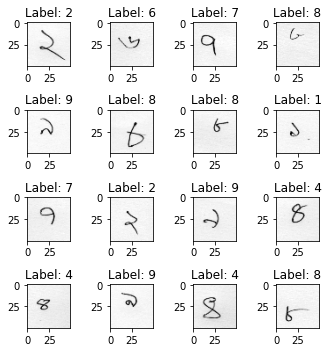

In [10]:
# Visualize the data 
visualize_data(X_train,labels_a,START_IDX,END_IDX)

In [12]:
# Setting a Keras Callback to reduce Learning Rate by 0.1 dynamically
callbacks_list = [
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss",
                      factor=FACTOR,
                      patience=PATIENCE
                  )
]
# Loading the neural network
model = ConvNetModel()
# Training 
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=callbacks_list)
print("Training complete!")

Epoch 1/35
2027/2027 [==============================] - 10s 5ms/step - loss: 0.3200 - accuracy: 0.8965 - val_loss: 0.2397 - val_accuracy: 0.9270
Epoch 2/35
2027/2027 [==============================] - 10s 5ms/step - loss: 0.1236 - accuracy: 0.9622 - val_loss: 0.2001 - val_accuracy: 0.9406
Epoch 3/35
2027/2027 [==============================] - 10s 5ms/step - loss: 0.0942 - accuracy: 0.9719 - val_loss: 0.1653 - val_accuracy: 0.9532
Epoch 4/35
2027/2027 [==============================] - 10s 5ms/step - loss: 0.0821 - accuracy: 0.9747 - val_loss: 0.2992 - val_accuracy: 0.9344
Epoch 5/35
2027/2027 [==============================] - 10s 5ms/step - loss: 0.0662 - accuracy: 0.9811 - val_loss: 0.1347 - val_accuracy: 0.9650
Epoch 6/35
2027/2027 [==============================] - 10s 5ms/step - loss: 0.0543 - accuracy: 0.9836 - val_loss: 0.1715 - val_accuracy: 0.9646
Epoch 7/35
2027/2027 [==============================] - 10s 5ms/step - loss: 0.0514 - accuracy: 0.9849 - val_loss: 0.1384 - val_ac

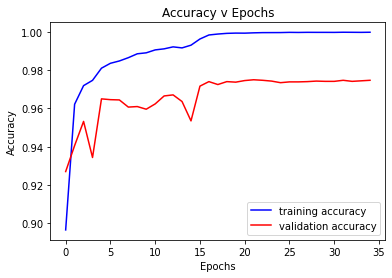

In [13]:
model.save("bangla_classifier_full.h5")
history_dict = history.history
# Visualize the accuracy curve over the course of training
plot_accuracy(history_dict, len(history_dict["accuracy"]))

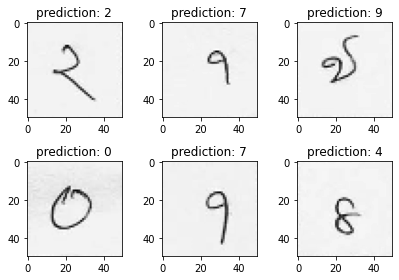

In [19]:
predict("/content/sample_data/predict")

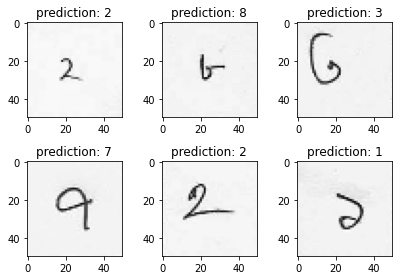

In [21]:
predict("/content/sample_data/predict_2")

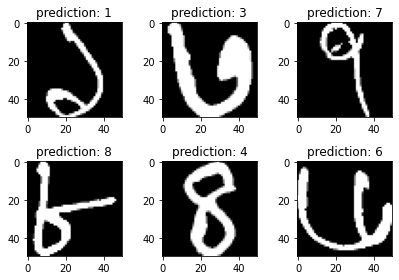

In [22]:
predict("/content/sample_data/predict_3")

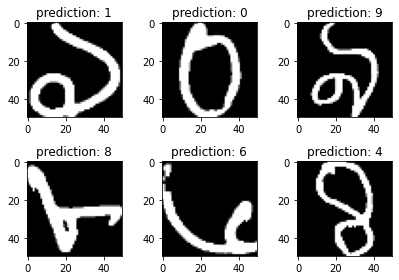

In [23]:
predict("/content/sample_data/predict_4")